# Abstract

Creating a model that predicts fatality of crashes can give more insight into what factors play into the deaths occur in a crash. For this case study, an artificial neural network with 3 hidden layers is used to predict the outcome of crashes. To compensate for the data imbalance prevailant in the target variable, the oversampling process called SMOTE is utilized to supplement the training data to better identify fatality. The main metric for evaluating the model's performance is recall, since it is not ideal for the model to register many false negatives in this scenario (i.e. predicting a non-fatal outcome for the actual fatal outcome). The model yielded a recall value of 0.352.  

# Pipeline

## Installing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.optimizers import Adam, Adamax, Adagrad, Adadelta
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score




/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading the Dataset

In [2]:
df_raw = pd.read_csv('Crash_Details_Table.csv')
df_raw.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,OBJECTID,CRIMEID,CCN,PERSONID,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,VEHICLEID,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
0,438194351,26872544,16034312,84628234,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
1,438194352,26872544,16034312,84833902,Passenger,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,Y,N
2,438194353,26872544,16034312,84938064,Driver,NaN,N,N,N,2275007,Passenger Car/automobile,N,None,N,N
3,438194354,26872544,16034312,84790164,Driver,31.0,N,N,N,2275009,Passenger Car/automobile,N,VA,N,N
4,438194355,26872544,16034312,84953497,Passenger,47.0,N,N,Y,2275008,Passenger Car/automobile,N,VA,Y,N


In [3]:
df_raw.shape

(596381, 15)

## Description of Dataset

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596381 entries, 0 to 596380
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   OBJECTID           596381 non-null  int64  
 1   CRIMEID            596381 non-null  int64  
 2   CCN                596381 non-null  object 
 3   PERSONID           596381 non-null  int64  
 4   PERSONTYPE         596381 non-null  object 
 5   AGE                426744 non-null  float64
 6   FATAL              596381 non-null  object 
 7   MAJORINJURY        596381 non-null  object 
 8   MINORINJURY        596381 non-null  object 
 9   VEHICLEID          596381 non-null  object 
 10  INVEHICLETYPE      596381 non-null  object 
 11  TICKETISSUED       596381 non-null  object 
 12  LICENSEPLATESTATE  596381 non-null  object 
 13  IMPAIRED           596381 non-null  object 
 14  SPEEDING           596381 non-null  object 
dtypes: float64(1), int64(3), object(11)
memory usage: 6

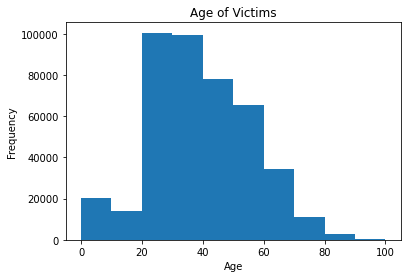

In [5]:
df_raw_age = df_raw[df_raw['AGE'].isna()==False]
plt.hist(df_raw_age['AGE'], range=[0,100])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age of Victims')
plt.show()

## Data Preprocessing

In [6]:
df = df_raw.fillna(np.median(df_raw_age['AGE']))
print('All "nan" value in age feature replaced with {}'.format(np.median(df_raw_age['AGE'])))
df.shape

All "nan" value in age feature replaced with 37.0


(596381, 15)

In [7]:
df.columns

Index(['OBJECTID', 'CRIMEID', 'CCN', 'PERSONID', 'PERSONTYPE', 'AGE', 'FATAL',
       'MAJORINJURY', 'MINORINJURY', 'VEHICLEID', 'INVEHICLETYPE',
       'TICKETISSUED', 'LICENSEPLATESTATE', 'IMPAIRED', 'SPEEDING'],
      dtype='object')

In [8]:
features =['PERSONTYPE', 'AGE', 'FATAL', 'MAJORINJURY', 'MINORINJURY',
       'INVEHICLETYPE', 'TICKETISSUED', 'LICENSEPLATESTATE', 'IMPAIRED', 'SPEEDING']

In [9]:
df = df[features]

In [10]:
for feature in df.columns:
  if df[feature].dtype == 'object':
    num_category = len(df[feature].value_counts())
    print('Number of categories for {} : {}'.format(feature, num_category))

Number of categories for PERSONTYPE : 4
Number of categories for FATAL : 2
Number of categories for MAJORINJURY : 2
Number of categories for MINORINJURY : 2
Number of categories for INVEHICLETYPE : 22
Number of categories for TICKETISSUED : 2
Number of categories for LICENSEPLATESTATE : 60
Number of categories for IMPAIRED : 2
Number of categories for SPEEDING : 2


In [11]:
count_licence = df['LICENSEPLATESTATE'].value_counts()
count_licence_percent = count_licence/len(df)*100 
good_categories_index = [i for i, val in enumerate(count_licence_percent) if val >=5]
good_categories = count_licence[good_categories_index]
list(good_categories.index)

['DC', 'MD', 'VA', ' None']

In [12]:
new_categories = list(good_categories.index)
df['LICENSEPLATESTATE'] = df['LICENSEPLATESTATE'].apply(lambda x: x if x in new_categories else 'Other')

In [13]:
count_vehicle = df['INVEHICLETYPE'].value_counts()
count_vehicle_percent = count_vehicle/len(df)*100
good_categories_index = [i for i, val in enumerate(count_vehicle_percent) if val >=5]
good_categories = count_vehicle[good_categories_index]
list(good_categories.index)

['Passenger Car/automobile', 'Other Vehicle', 'Suv (sport Utility Vehicle)']

In [14]:
new_categories = list(good_categories.index)
df['INVEHICLETYPE'] = df['INVEHICLETYPE'].apply(lambda x: x if x in new_categories else 'Other Vehicle')

In [15]:
df.head()

,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
0,Passenger,31.0,N,N,N,Passenger Car/automobile,N,VA,Y,N
1,Passenger,31.0,N,N,N,Passenger Car/automobile,N,VA,Y,N
2,Driver,37.0,N,N,N,Passenger Car/automobile,N,None,N,N
3,Driver,31.0,N,N,N,Passenger Car/automobile,N,VA,N,N
4,Passenger,47.0,N,N,Y,Passenger Car/automobile,N,VA,Y,N


## Exploratory Data Analysis

### Fatality Rate

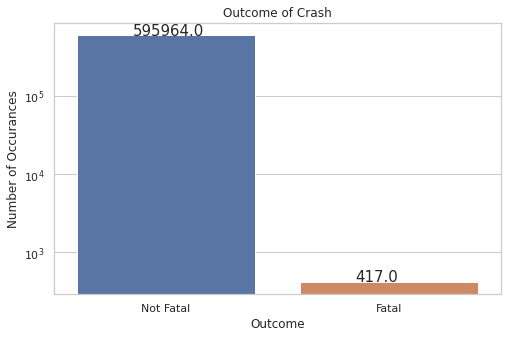

In [16]:
count_fatal = pd.DataFrame(df['FATAL'].value_counts())

plt.figure(figsize=(8,5))
sns.set(style='whitegrid')
ax = sns.barplot(x=count_fatal.index, y=count_fatal['FATAL'])
ax.set(xlabel='Outcome', ylabel='Number of Occurances')
ax.set_title('Outcome of Crash')
ax.set_yscale('log')
ax.set_xticklabels(['Not Fatal', 'Fatal'])

for bar in ax.patches:
  ax.text(bar.get_x()+0.25, bar.get_height()+10, str(round(bar.get_height(),2)), fontsize=15)
# annotate bar chart

plt.show()

### Victim Age

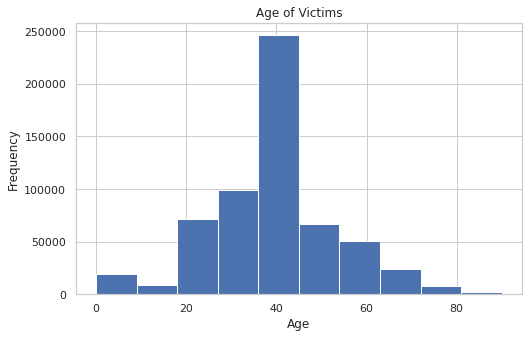

In [17]:
plt.figure(figsize=(8,5))
plt.hist(df['AGE'], range=[0,90])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age of Victims')
plt.show()

### License Plate States

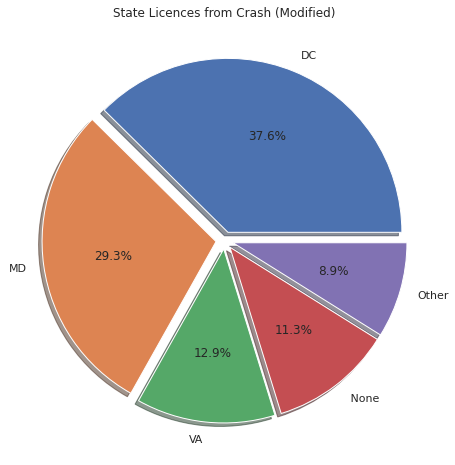

In [18]:
plt.figure(figsize=(8,8))
count_licence = df['LICENSEPLATESTATE'].value_counts()
explode = [.05 for _ in range(len(count_licence))]
label = count_licence.index
plt.pie(count_licence, explode=explode, labels=label, shadow=True, autopct='%1.1f%%')
plt.title('State Licences from Crash (Modified)')
plt.show()

### Vehicle Type

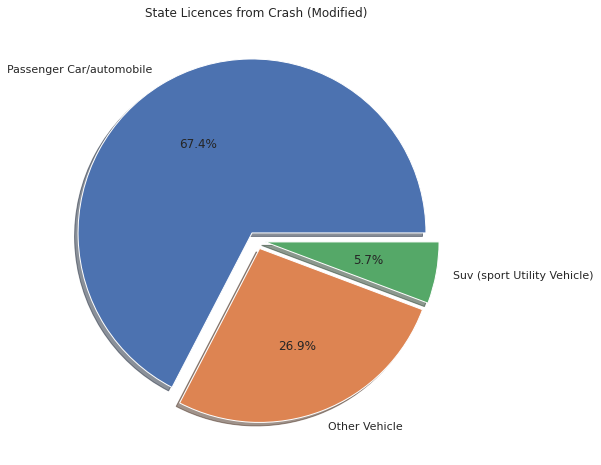

In [19]:
plt.figure(figsize=(8,8))
count_vehicle = df['INVEHICLETYPE'].value_counts()
explode = [.05 for _ in range(len(count_vehicle))]
label = count_vehicle.index
plt.pie(count_vehicle, explode=explode, labels=label, shadow=True, autopct='%1.1f%%')
plt.title('State Licences from Crash (Modified)')
plt.show()

In [20]:
df.columns

Index(['PERSONTYPE', 'AGE', 'FATAL', 'MAJORINJURY', 'MINORINJURY',
       'INVEHICLETYPE', 'TICKETISSUED', 'LICENSEPLATESTATE', 'IMPAIRED',
       'SPEEDING'],
      dtype='object')

## Model Selection

In [21]:
for feature in df.columns:
  if len(df[feature].value_counts()) == 2:
    df[feature] = df[feature].map({'N':0, 'Y':1})
df = pd.get_dummies(df)
df.head()

,AGE,FATAL,MAJORINJURY,MINORINJURY,TICKETISSUED,IMPAIRED,SPEEDING,PERSONTYPE_Bicyclist,PERSONTYPE_Driver,PERSONTYPE_Passenger,PERSONTYPE_Pedestrian,INVEHICLETYPE_Other Vehicle,INVEHICLETYPE_Passenger Car/automobile,INVEHICLETYPE_Suv (sport Utility Vehicle),LICENSEPLATESTATE_ None,LICENSEPLATESTATE_DC,LICENSEPLATESTATE_MD,LICENSEPLATESTATE_Other,LICENSEPLATESTATE_VA
0,31.0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
1,31.0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
2,37.0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
3,31.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,47.0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1


In [22]:
df.shape

(596381, 19)

In [23]:
target = 'FATAL'

In [24]:
X = df.drop(target, axis=1)
y = df[target]

Counter(y)

Counter({0: 595964, 1: 417})

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

X_train, X_valid, y_train, y_valid = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)

print('X_train dimensions: ',X_train.shape)
print('y_train dimensions: ',y_train.shape)
print('X_test dimensions: ',X_test.shape)
print('y_test dimensions: ',y_test.shape)
print('X_valid dimensions: ',X_valid.shape)
print('y_valid dimensions: ',y_valid.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


X_train dimensions:  (584043, 18)
y_train dimensions:  (584043,)
X_test dimensions:  (178915, 18)
y_test dimensions:  (178915,)
X_valid dimensions:  (250305, 18)
y_valid dimensions:  (250305,)


In [26]:
counter = Counter(y_test)
counter

Counter({0: 178790, 1: 125})

In [27]:
# MinMaxScaler
mms = MinMaxScaler()

# Normalize the training data
X_train = mms.fit_transform(X_train)

# Normalize the training data
X_test = mms.fit_transform(X_test)

# Normalize the training data
X_valid = mms.fit_transform(X_valid)


### Support Vector Machine

### Neural Network

In [28]:
def create_model(learn_rate=0.0001, N_NEURONS=32):
  model = Sequential()
  model.add(Dense(N_NEURONS, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Dense(N_NEURONS, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(N_NEURONS, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1, activation='sigmoid'))

  # 0.001
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learn_rate), metrics=['accuracy'])

  return model

In [29]:
EPOCH = 10
BATCH_SIZE = 128
N_NEURONS = [64,128, 256]
learn_rate = [0.00005, 0.0001, 0.001]
param_grid = dict(learn_rate=learn_rate, N_NEURONS=N_NEURONS)

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128)
model.fit(X_train, y_train)


Epoch 1/10
4563/4563 [==============================] - 15s 3ms/step - loss: 0.5776 - accuracy: 0.6708
Epoch 2/10
4563/4563 [==============================] - 14s 3ms/step - loss: 0.4191 - accuracy: 0.7998
Epoch 3/10
4563/4563 [==============================] - 14s 3ms/step - loss: 0.3848 - accuracy: 0.8223
Epoch 4/10
4563/4563 [==============================] - 14s 3ms/step - loss: 0.3648 - accuracy: 0.8356
Epoch 5/10
4563/4563 [==============================] - 13s 3ms/step - loss: 0.3518 - accuracy: 0.8431
Epoch 6/10
4563/4563 [==============================] - 14s 3ms/step - loss: 0.3421 - accuracy: 0.8502
Epoch 7/10
4563/4563 [==============================] - 14s 3ms/step - loss: 0.3345 - accuracy: 0.8532
Epoch 8/10
4563/4563 [==============================] - 14s 3ms/step - loss: 0.3278 - accuracy: 0.8570
Epoch 9/10
4563/4563 [==============================] - 14s 3ms/step - loss: 0.3221 - accuracy: 0.8593
Epoch 10/10
4563/4563 [==============================] - 14s 3ms/step - l

In [30]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=3, scoring='f1_macro')
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 54.8min finished


Epoch 1/10
4563/4563 [==============================] - 47s 10ms/step - loss: 0.3970 - accuracy: 0.8056
Epoch 2/10
4563/4563 [==============================] - 46s 10ms/step - loss: 0.2736 - accuracy: 0.8767
Epoch 3/10
4563/4563 [==============================] - 46s 10ms/step - loss: 0.2477 - accuracy: 0.8902
Epoch 4/10
4563/4563 [==============================] - 46s 10ms/step - loss: 0.2300 - accuracy: 0.8975
Epoch 5/10
4563/4563 [==============================] - 47s 10ms/step - loss: 0.2184 - accuracy: 0.9023
Epoch 6/10
4563/4563 [==============================] - 47s 10ms/step - loss: 0.2078 - accuracy: 0.9066
Epoch 7/10
4563/4563 [==============================] - 47s 10ms/step - loss: 0.1971 - accuracy: 0.9109
Epoch 8/10
4563/4563 [==============================] - 47s 10ms/step - loss: 0.1927 - accuracy: 0.9138
Epoch 9/10
4563/4563 [==============================] - 46s 10ms/step - loss: 0.1870 - accuracy: 0.9167
Epoch 10/10
4563/4563 [==============================] - 47s 10m

In [31]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


In [32]:
for mean, stdev, param in reversed(sorted(zip(means, stds, params))):
    print('mean: {}, std: {}, param: {}'.format(mean, stdev, param))

mean: 0.9225620596415168, std: 0.0015563327065863705, param: {'N_NEURONS': 256, 'learn_rate': 0.0001}
mean: 0.9171030380420188, std: 0.0025662368769372155, param: {'N_NEURONS': 256, 'learn_rate': 0.001}
mean: 0.9141408148493692, std: 0.0014660890495735938, param: {'N_NEURONS': 128, 'learn_rate': 0.001}
mean: 0.9108673854914646, std: 0.0011458665600863323, param: {'N_NEURONS': 64, 'learn_rate': 0.001}
mean: 0.9079478835469321, std: 0.0023672031617937043, param: {'N_NEURONS': 128, 'learn_rate': 0.0001}
mean: 0.8973636275397858, std: 0.0020692543164643772, param: {'N_NEURONS': 64, 'learn_rate': 0.0001}
mean: 0.8554711243494509, std: 0.025811745253739707, param: {'N_NEURONS': 256, 'learn_rate': 0.01}
mean: 0.8188383163650096, std: 0.028312760155015767, param: {'N_NEURONS': 64, 'learn_rate': 0.01}
mean: 0.8050694957703822, std: 0.04339207647088461, param: {'N_NEURONS': 128, 'learn_rate': 0.01}


In [34]:
best_model = create_model(learn_rate=0.0001, N_NEURONS=256)
callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
best_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, verbose=2, epochs=20, callbacks=[callback])

Epoch 1/20
4563/4563 - 40s - loss: 0.3396 - accuracy: 0.8411 - val_loss: 0.6045 - val_accuracy: 0.7443
Epoch 2/20
4563/4563 - 38s - loss: 0.2677 - accuracy: 0.8793 - val_loss: 0.4405 - val_accuracy: 0.8086
Epoch 3/20
4563/4563 - 43s - loss: 0.2469 - accuracy: 0.8897 - val_loss: 0.4403 - val_accuracy: 0.7967
Epoch 4/20
4563/4563 - 38s - loss: 0.2310 - accuracy: 0.8970 - val_loss: 0.4580 - val_accuracy: 0.7830
Epoch 5/20
4563/4563 - 39s - loss: 0.2164 - accuracy: 0.9036 - val_loss: 0.7703 - val_accuracy: 0.7781
Epoch 6/20
4563/4563 - 38s - loss: 0.2046 - accuracy: 0.9079 - val_loss: 1.0980 - val_accuracy: 0.7524
Epoch 7/20
4563/4563 - 38s - loss: 0.1963 - accuracy: 0.9118 - val_loss: 1.3938 - val_accuracy: 0.7233
Epoch 8/20
4563/4563 - 38s - loss: 0.1906 - accuracy: 0.9147 - val_loss: 1.5685 - val_accuracy: 0.7146
Epoch 9/20
4563/4563 - 39s - loss: 0.1859 - accuracy: 0.9168 - val_loss: 1.8730 - val_accuracy: 0.7096
Epoch 10/20
4563/4563 - 39s - loss: 0.1824 - accuracy: 0.9178 - val_loss:

In [36]:
best_model = load_model('best_model.h5')
y_test_pred = best_model.predict(X_test)
y_test_pred = np.round(y_test_pred)
y_test_pred[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [37]:
print('Number of observations in the testing set: ',len(y_test))
Counter(y_test)


Number of observations in the testing set:  178915


Counter({0: 178790, 1: 125})

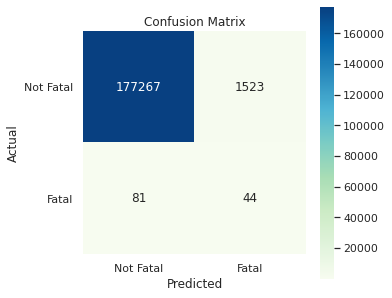

In [38]:
matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,5))
ax = sns.heatmap(matrix, square=True, annot=True, fmt='d',cbar=True, cmap=plt.cm.GnBu)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

class_labels = ['Not Fatal', 'Fatal']
ax.set_xticklabels(class_labels, rotation=0)
ax.set_yticklabels(class_labels, rotation=0)
ax.set_title('Confusion Matrix')
plt.show()

In [40]:
# calculate recall
recall = recall_score(y_true=y_test, y_pred=y_test_pred)
print('The recall score of this model is: ',recall)

The recall score of this model is:  0.352


## Interpretation

As can be seen from the sheer contrast in the number of fatal crashes and non-fatal crashes, the model for predicting fatality must consider the imbalance in data. This is addressed with oversampling (SMOTE), which entails training the model with artificial data of fatal observations in tandem with the actual training data. Since it is ideal for the model to predict a fatal crash correctly (true positive) and not predict a non-fatal outcome for a fatal outcome (false negative), the recall value is the main metric for evaluating the performance of the model. 

  The model achieves a recall value of 0.352. Furthermore, out of the 178915 samples in the testing set, 177311 were predicted accurately by the model. However, the model also registed 1523 false positives and 81 false negatives. 

# Discussion

There are certainly measures that can be taken to improve the performance of the model. Firstly, the assumptions made during the preprocessing phase of the procedure must be revisited. Also, although an artificial neural network is suitable for classification tasks, other machine learning algorithms (e.g. support vector machine) should also be tested. Finally, for a finely tuned model, a greater number of combinations of parameters should be tested to determine the best values for the parameters in the model. 

In addition to altering the data science techniques implemented, the data itself should be scrutinized. For instance, are there any features not included in the dataset that should be? Perhaps, which the inclusion of other variables, the model can return more satisfactory results. 